![NCAR UCAR Logo](img/NCAR_CISL_NSF_banner.jpeg)
# Python GPU Session: CuPy and Legate

By: Brett Neuman [bneuman@ucar.edu](mailto:bneuman@ucar.edu), Consulting Services Group, CISL & NCAR

Date: July 28th 2022

Head to the [NCAR JupyterHub portal](https://jupyterhub.hpc.ucar.edu/stable) and __start a JupyterHub session on a Casper batch node__ (using 1 CPU, 1 GPU) and open the notebook in `12_CuPyAndLegate.ipynb`. Be sure to clone (if needed) and update/pull the NCAR GPU_workshop directory.

```shell
# Use the JupyterHub GitHub GUI on the left panel or the below shell commands
git clone git@github.com:NCAR/GPU_workshop.git
git pull
```

# Workshop Etiquette
* Please mute yourself and turn off video during the session.
* Questions may be submitted in the chat and will be answered when appropriate. You may also raise your hand, unmute, and ask questions during Q&A at the end of the presentation.
* By participating, you are agreeing to [UCAR’s Code of Conduct](https://www.ucar.edu/who-we-are/ethics-integrity/codes-conduct/participants)
* Recordings & other material will be archived & shared publicly.
* Feel free to follow up with the GPU workshop team via Slack or submit support requests to [support.ucar.edu](https://support.ucar.edu)
    * Office Hours: Asynchronous support via [Slack](https://ncargpuusers.slack.com) or schedule a time with an organizer

## Notebook Setup
This notebook will require running within a JupyterHub PBS Batch (interactive) session.  Much of the Python code will fail if a GPU is not detected on the node.  Select the PBS Batch option when launching from JupyterHub and set the `PROJECT` code to a currently active project, ie `UCIS0004` for the GPU workshop, and `QUEUE` to the appropriate routing queue depending on if during a live workshop session (`gpuworkshop`), during weekday 8am to 5:30pm MT (`gpudev`), or all other times (`casper`). Due to limited shared GPU resources, please use `GPU_TYPE=gp100` during the workshop. Otherwise, set `GPU_TYPE=v100` (required for `gpudev`) for independent work. See [Casper queue documentation](https://arc.ucar.edu/knowledge_base/72581396#StartingCasperjobswithPBS-Concurrentresourcelimits) for more info.

If running this notebook outside of the NCAR computing environment, a compatible GPU is required on a node or your local machine to execute the code in the CuPy sections of this notebook.

### Changing Notebook Kernel

You'll need to use a JupyterHub kernel that has the CuPy module.  There are several ways to do this but you can navigate to the `Kernel` dropdown and select `Change Kernel`.  Select **GPU Workshop** kernel from the dropdown to run the CuPy examples in this notebook.

## Python Virtual Environment Setup

You can set up your own virtual environment for running the Python code outside of this notebook.  This will also be useful if you would like to create your own virtual environment for GPU programming experimentation with Python.

See [Python virtual environment documentation](https://kb.ucar.edu/display/RC/Using+conda+environments+for+Python+access) for using the NCAR Python Library (npl) or for setting up your own virtual environment.  Here is a bash example for creating your own virtual environment.

```bash
# Conda used for virtual environment in NCAR clusters
module load conda/latest
# Create your own virtual environment named 'pygpu'
mamba create -n pygpu python==3.7.9 numpy scipy matplotlib pandas geocat-comp xarray dask wrf-python cupy 
# Use the virtual environment (don't forget to deactivate "conda deactivate")
conda activate pygpu

# You can also create a virtual environment from existing .yml file
conda env create --file envs/environment.yml
```

----

# Python GPU Itinerary

1) Python GPU Programming Overview
2) CuPy
    - Overview and Setup
    - Basic Drop-in Replacement Example
    - Computational Fluid Dynamics Example
    - Additional CuPy Functionality
    - GeoCAT Example   
3) Legate
    - Overview, Philosophy, and Setup
    - Basic Drop-in Replacement Examples

----

## GPU Acceleration Overview

The Central Processing Unit (CPU) is a low latency focused, general purpose processor that handles sequential and complex tasks well.  The Graphics Processing Unit (GPU) is a throughput focused set of computational units that excel at parallel processing, particularly on single instruction, multiple data (SIMD) type problems.  The decision to port your code to run on a GPU is problem independent.

|  |  |
| :--- | :--- | 
| **CPU** | **GPU** |
| Several cores | Many cores |
| Low latency | High throughput |
| Good for serial processing | Good for parallel processing |
| Can do a handful of operations at once| Can do thousands of operations at once |

It is important to be able to identify problem types that are likely to benefit from porting code to the GPU.  Python offers APIs that make quick drop-in replacement of an entire code tempting but this can still take significant time, especially verifying correctness of your changes.

*Source:* https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/

The NCAR GPU Workshop series contains more detailed information on GPU programming topics.

## Interpreted vs. Compiled Languages for GPU Programming

Python is a partially interpreted language, meaning that the code requires an additional step to run as machine code. This additional step will need to be considered when writing performant code.  One trade off for Python's platform independence, dynamic typing, and modularity is the additional step to interpret the bytecode generated by Python and then running machine code on your device.

|  |  |
| :--- | :--- | 
| **Interpreted** | **Compiled** |
| Ease of use | Performance |
| Parsed, Interpreted, and Executed each time run | Compilation overhead occurs once |
| Lenient datatype enforcement | Strict datatype enforcement |
| Platform independent | Platform dependent |

Fortran and C/C++ examples of languages that are translated by running the source code through a compiler. This results in very efficient code that can be executed any number of times. The overhead for the translation is incurred just once, when the source is compiled.

Interpreted languages must be parsed, interpreted, and executed each time the program is run, thereby greatly adding to the cost of running the program. For this reason, interpreted programs are usually less efficient than compiled programs.  The trade-off is machine resources for programmer time.

Keeping this in mind, we can very generally say that it would make sense to use a compiled language for the intensive parts of an application, whereas interpreted could be use for more rapid prototyping, experimentation, or low computational workload sections of an application.

*Source:* https://www.ibm.com/docs/en/zos-basic-skills?topic=zos-compiled-versus-interpreted-languages

Some of the considerations for needed for compiled languages that are potentially hidden from Python GPU implementations:
  - Memory movement
  - Garbage collection
  - Instruction flow
  - Loop control
  - Parallelization

Comparing a Python GPU implementation to the CUDA / C implementation:

![gpu_py_c.png](img/gpu_py_c.png)
*Source: NCAR SIParCS 2022 Haniye Kashgarani (Implementation of GeoCat on GPUs)*

### Compiled Python

Compiled Python allows calls to compiled subsections of Python code.  Common compilation options include Cython and Numba which uses the Just-In-Time (JIT) compiler.  Compiled sections of code often see a performance boost from running the code in a compiled language and avoids the slowdowns from interpreted drawbacks covered in the previous section.  Compiled Python provides opportunities for improved performance at the cost of programming ease.

We'll provide an example of a custom kernel that uses Compiled Python near the end of the notebook. 

## Python Scientific Computing Tools for the GPU

Many of the tools to enable performant Python code on the GPU attempt to be drop-in replacements.  Well known modules Numpy, Scipy, and Pandas are primary targets for GPU porting efforts.

You might be familiar with GPU accelerated Python ecosystems such as TensorFlow, PyTorch, or RAPIDS.  These tools attempt to provide a suite of APIs to cover specific areas of research, most commonly for data science.  Our focus today won't be on these broader scope suites but on individual APIs that allow developers to port their code with drop-in replacements for common scientific computing modules.

Drop-in replacement is used to describe a new API or module that can be imported but retains the function syntax of another module.  The user can replace the module name and expect the function calls to remain the same.

One consideration introduced with Python GPU programming is portability.  Different tools used for Python GPU programming need to be designed for specific device families.

Below is a chart showing scientific computing GPU APIs, device compatibility, and additional compute functionality for known Python GPU programming tool suites: 

![Python GPU Chart](img/pygpuchart.png)
  
    (* : Options to use compiled Python)
    
----

# CuPy

![CuPy Logo](img/cupy_logo.png)

CuPy is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python. CuPy acts as a drop-in replacement to run existing NumPy/SciPy code on NVIDIA CUDA or AMD ROCm platforms.

CuPy provides a ndarray, sparse matrices, and the associated routines for GPU devices, all having the same API as NumPy and SciPy.

CuPy's stated goal is to *provide Python users GPU acceleration capabilities, without the in-depth knowledge of underlying GPU technologies. The CuPy team focuses on providing:*

  - *A complete NumPy and SciPy API coverage to become a full drop-in replacement plus advanced CUDA features to maximize performance.*

  - *A quality, mature, and fundamental package for all projects needing acceleration at any scale.*

[CuPy Homepage](https://docs.cupy.dev/en/stable/index.html#)

[CuPy Github](https://github.com/cupy/cupy)


## Setup

### Requirements

NVIDIA CUDA GPU with the Compute Capability 3.0+.

CUDA Toolkit: v10.2 / v11.0 / v11.1 / v11.2 / v11.3 / v11.4 / v11.5 / v11.6 / v11.7

Python: 
  - Versions: v3.7.0+ / v3.8.0+ / v3.9.0+ / v3.10.0+
  - Modules: Numpy, SciPy (optional)
  
CuPy's [Installation](https://docs.cupy.dev/en/stable/install.html) page has step-by-step details to install using pip, conda, or from source.  Setting up your virtual environment to include CuPy is an easy way to maintain package dependencies and share your code with others. 

### Importing

At the most basic setup, import the CuPy module in your Python file:

```python
import cupy as cp
```

Then use `cp` instead of Numpy's standard `np` to create arrays and perform computations.  

Another option to determine if CuPy is available is to check during import.  This method checks if CuPy is available and avoids errors on import. 

```python
def _import_cupy():
    """imports the cupy and checks if not installed"""
    try:
        import cupy as cp
        return cp
    except ImportError as e:
        print(f"Cupy is not installed for GPU computation!")
        pass  # module doesn't exist, deal with it. 
```
*Source: Haniye Kashgarani SIParCS GeoCAT GPU Project*

We'll go through a couple of examples below and then provide resources to see which Numpy functions have been implemented in the CuPy API.

## CuPy Functions Walkthrough

### Import Numpy and Cupy

In [1]:
import cupy as cp
import numpy as np

### Creating Arrays on the CPU and GPU

Let's start by using some basic Numpy functions to create arrays and how that same procedure is done in CuPy.

In [2]:
# NumPy data (host / cpu)
x_cpu = np.linspace(0, 2, 5)
print("On the CPU: ", x_cpu)

# CuPy data
x_gpu = cp.linspace(2, 4, 5)
print("On the GPU: ", x_gpu)

On the CPU:  [0.  0.5 1.  1.5 2. ]
On the GPU:  [2.  2.5 3.  3.5 4. ]


### Moving data between host and device

In [3]:
# Move data to GPU
x_gpu = cp.asarray(x_cpu)

# Move data back to host
x_cpu = cp.asnumpy(x_gpu)

### Device Information

Combined with the `nvidia-smi` command you can identify then use devices with CuPy.  This would become more important if extended your code to multiple GPUs.  The default behavior runs code on Device 0.  Here is an example of forcing an operation to run on Device 0:

In [4]:
with cp.cuda.Device(0):
    x_on_gpu0 = cp.array([1, 2, 3, 4, 5])
x_on_gpu0 = cp.array([1, 2, 3, 4, 5])
print("X on GPU0: ", x_on_gpu0)

X on GPU0:  [1 2 3 4 5]


### CuPy Implemented Functions

CuPy has equivalents for many of the commonly used Numpy functions, but not all.  Here is a short list of the Numpy function with it's CuPy equivalent.  You can see almost all of CuPy's functions will use the same function call as it's Numpy equivalent.

| | |
| :--- | :--- |
| **Numpy** | **CuPy** |
| numpy.identity        | cupy.identity       |
| numpy.matmul        | cupy.matmul       |
| numpy.nan_to_num        | cupy.nan_to_num       |
| numpy.zeros        | cupy.zeros       |
| numpy.ones        | cupy.ones       |
| numpy.shape        | cupy.shape       |
| numpy.reshape        | cupy.reshape       |
| numpy.tensordot        | cupy.tensordot       |
| numpy.transpose        | cupy.transpose       |
| numpy.fft.fft        | cupy.fft.fft       |

CuPy also has equivalent functions used within SciPy but fewer are implemented than Numpy.  A full list of Cupy's Numpy and Scipy equivalent functions are provided on the link below.

[Complete Comparison of Numpy and Scipy to CuPy functions](https://docs.cupy.dev/en/stable/reference/comparison.html)

[CuPy API Reference](https://docs.cupy.dev/en/stable/reference/index.html)

----

## Numpy to Cupy Example

Here we want to show an example of easily porting a short script to run on the GPU.  We'll import some time series data and extract simple statistics on both the CPU and the GPU.


### The Gravity Recovery and Climate Experiment (GRACE) Dataset

Refers to a pair of NASA satellites that has flown in low-Earth orbit since 2002.  We've collected a time series data representation of mean annual amplitude of total water storage in a 200km square area near Colorado:

Import matplotlib for visualization of the time series data.

In [5]:
import matplotlib.pyplot as plt

### CPU Implementation

Min: -85.16 
Max: 69.28 
Mean: -10.16


Text(0.5, 1.0, 'GRACE Time Series on CPU')

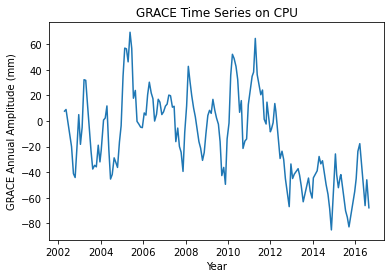

In [6]:
# Pull in the time series data to CPU
data_cpu = np.loadtxt("code/gracets/data/grace_raw.o")

# Separate dates and amplitude
date_cpu = data_cpu[:, 0]
amp_cpu = data_cpu[:, 1]

# Get min, max, and mean from amplitude
y_min_cpu = np.min(amp_cpu)
y_max_cpu = np.max(amp_cpu)
y_mean_cpu = np.round(np.mean(amp_cpu), 2)
print("Min:", y_min_cpu, "\nMax:", y_max_cpu, "\nMean:", y_mean_cpu)

# Plot the time series
ts = plt.plot(date_cpu, amp_cpu)
plt.xlabel("Year")
plt.ylabel("GRACE Annual Amplitude (mm)")
plt.title("GRACE Time Series on CPU")

### GPU Implementation

Min: -85.16 
Max: 69.28 
Mean: -10.16


Text(0.5, 1.0, 'GRACE Time Series on GPU')

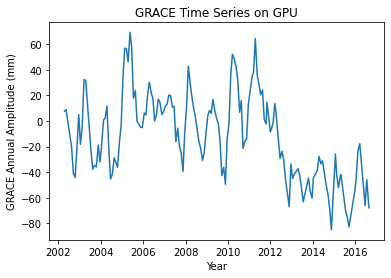

In [7]:
# Pull in the time series data to GPU
data_gpu = cp.loadtxt("code/gracets/data/grace_raw.o")

# Separate dates and amplitude
date_gpu = data_gpu[:, 0]
amp_gpu = data_gpu[:, 1]

# Get min, max, and mean from amplitude
y_min_gpu = cp.min(amp_gpu)
y_max_gpu = cp.max(amp_gpu)
y_mean_gpu = cp.round(cp.mean(amp_gpu), 2)
print("Min:", y_min_gpu, "\nMax:", y_max_gpu, "\nMean:", y_mean_gpu)

# Conversion back to Numpy to plot the data on the CPU
ts = plt.plot(cp.asnumpy(date_gpu), cp.asnumpy(amp_gpu))
plt.xlabel("Year")
plt.ylabel("GRACE Annual Amplitude (mm)")
plt.title("GRACE Time Series on GPU")

*GRACE Source:* Swenson, Sean & National Center for Atmospheric Research Staff (Eds). Last modified 08 Oct 2013. "The Climate Data Guide: GRACE: Gravity Recovery and Climate Experiment: Surface mass, total water storage, and derived variables." Retrieved from https://climatedataguide.ucar.edu/climate-data/grace-gravity-recovery-and-climate-experiment-surface-mass-total-water-storage-and.

## Developing for both CPU and GPU

Once you begin porting code to the GPU you will have to consider how to handle creating data on either the CPU or GPU.  CuPy has the ability to identify array types to write device agnostic code.  Below is a code sample using the community standard for reading an array and setting the package to use either Numpy or Cupy based on the type.

```python
xp = cp.get_array_module(x)
xp.linspace(0, 2, 5)
```

In [8]:
def addone(x):
    xp = cp.get_array_module(x)
    print("Using:", xp.__name__)
    return x+1


# Calls and Output
print(addone(x_cpu))
print(addone(x_gpu))

Using: numpy
[1.  1.5 2.  2.5 3. ]
Using: cupy
[1.  1.5 2.  2.5 3. ]


There are other possibilities to consider when writing CPU and GPU compatible code:
  - Separate development branches for GPU code
  - Implementing GPU Flags within code to use the GPU portion of your code
  - Allocating all Numpy or Cupy datatypes with a function or script
 
You may also need to consider new unit or regression tests to verify your GPU code does not inject any unexpected behavior both on the CPU and GPU side.

## Computational Fluid Dynamics (CFD) Example

Let's look at an example where you might expect performance improvements by running it on the GPU.  The [12 Step's to Navier-Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/) program was designed by Lorena Barba at George Washington University to help students learn and implement a Navier-Stokes finite-difference solver using Python.  Our example looks at the cavity flow, which solves the system of 2D Navier-Stokes differential equations.

Below are the computationally intensive discretized equations used to solve for u, v, and p in the Cavity Flow problem:

![Discretized Steps](img/uvp_cfd.png)

More detail on this specific step can be found on the website:

[12 Steps to Navier Stokes: Step 11 Cavity Flow](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb)

We'll walk through steps to implement the GPU version of this code and also compare the performance results between the CPU and GPU.

### File Locations and Descriptions
  
In the `code` folder there are several Python files used to create these results.  Feel free to view and modify these files to experiment further.

|Folder |File |Description |
|:--- |:--- |:--- |
|Numpy   |                             |                                         |
|        | step11_numpy.py                | cpu numpy using float       |
|        | step11_numpy_double.py         | cpu numpy using double              |
|Cupy    |                             |                                         |
|        | step11_cupy.py              | cpu/gpu agnostic with gpu flag using float   |
|        | step11_cupy_double.py       | cpu/gpu agnostic with gpu flag using double  |
|        | step11_nsight.py              | cpu/gpu with cupyx profiler nvtx flags for nsight  |

### CPU Implementation

Below we initialize the data used in our application with Numpy.  This will run on the CPU and use whatever default Numpy optimizations:

```python
    def _init_params(self, n):
        # NumPy setup
        self.x = np.linspace(0, 2, n)
        self.y = np.linspace(0, 2, n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        self.u = np.zeros((n, n))
        self.v = np.zeros((n, n))
        self.p = np.zeros((n, n))         
        self.un = np.empty_like(self.u)
        self.vn = np.empty_like(self.v)
        self.pn = np.empty_like(self.p)
        self.b = np.zeros((n, n)) 
```

It should be noted that even the Numpy CPU implementation hides the computational heavy lifting unless you look for it.  Here is an example of uncertainity in how many threads Numpy will use by default:

https://stackoverflow.com/questions/30791550/limit-number-of-threads-in-numpy

### Basic GPU Port

Here we'll use the device agnostic method and a flag to determine how to allocate the data, either with Numpy on the host (CPU) or CuPy on the device (GPU).  Drop-in, device agnostic replacement:
  
```python

    class CavityFlow(object):
        # ...
        
        def __init__(self, dims, timesteps, use_gpu=False):
            # ...

        def _init_params(self, n):
            # CuPy setup
            if self.use_gpu:
                xp = cp
            else:
                xp = np

            self.x = xp.linspace(0, 2, n)
            self.y = xp.linspace(0, 2, n)
            self.X, self.Y = xp.meshgrid(self.x, self.y)
            self.u = xp.zeros((n, n))
            self.v = xp.zeros((n, n))
            self.p = xp.zeros((n, n))         
            self.un = xp.empty_like(self.u)
            self.vn = xp.empty_like(self.v)
            self.pn = xp.empty_like(self.p)
            self.b = xp.zeros((n, n))
        
```

### Import additional modules

In [9]:
from matplotlib import pyplot, cm
import time

### Class and Functions

In [10]:
# Cavity Flow Class
class CavityFlow(object):

    def __init__(self, dims, timesteps, use_gpu, plot_result):
        # Parameter Initialization
        self.n = dims
        self.nt = timesteps
        self.use_gpu = use_gpu
        self.plot_result = plot_result
        self.nit = 50
        self.c = 1
        self.dx = 2 / (self.n-1)
        self.dy = 2 / (self.n-1)
        self.rho = 1
        self.nu = 0.1
        self.dt = 0.0001

        self._init_params(self.n)

    def _init_params(self, n):
        # CuPy setup
        if self.use_gpu:
            xp = cp
        else:
            xp = np

        self.x = xp.linspace(0, 2, n, dtype=xp.double)
        self.y = xp.linspace(0, 2, n, dtype=xp.double)
        self.X, self.Y = xp.meshgrid(self.x, self.y)
        self.u = xp.zeros((n, n), dtype=xp.double)
        self.v = xp.zeros((n, n), dtype=xp.double)
        self.p = xp.zeros((n, n), dtype=xp.double)         
        self.un = xp.empty_like(self.u, dtype=xp.double)
        self.vn = xp.empty_like(self.v, dtype=xp.double)
        self.pn = xp.empty_like(self.p, dtype=xp.double)
        self.b = xp.zeros((n, n), dtype=xp.double)

    def plot(self):
        fig = pyplot.figure(figsize=(11,7), dpi=100)
        # plotting the pressure field as a contour
        pyplot.contourf(self.X, self.Y, self.p, alpha=0.5, cmap=cm.viridis)  
        pyplot.colorbar()
        # plotting the pressure field outlines
        pyplot.contour(self.X, self.Y, self.p, cmap=cm.viridis)  
        # plotting velocity field
        pyplot.quiver(self.X[::2, ::2], self.Y[::2, ::2], self.u[::2, ::2], self.v[::2, ::2]) 
        pyplot.xlabel('X')
        pyplot.ylabel('Y')
        pyplot.title('Cavity Flow')

    def _build_up_b(self):
        self.b[1:-1, 1:-1] = (self.rho * (1 / self.dt * 
                             ((self.u[1:-1, 2:] - self.u[1:-1, 0:-2]) / 
                             (2 * self.dx) + (self.v[2:, 1:-1] - self.v[0:-2, 1:-1]) / (2 * self.dy)) -
                             ((self.u[1:-1, 2:] - self.u[1:-1, 0:-2]) / (2 * self.dx))**2 -
                             2 * ((self.u[2:, 1:-1] - self.u[0:-2, 1:-1]) / (2 * self.dy) *
                             (self.v[1:-1, 2:] - self.v[1:-1, 0:-2]) / (2 * self.dx))-
                             ((self.v[2:, 1:-1] - self.v[0:-2, 1:-1]) / (2 * self.dy))**2))

    def _pressure_poisson(self):
        self.pn = cp.copy(self.p)
        for q in range(self.nit):
            self.pn = self.p.copy()
            self.p[1:-1, 1:-1] = (((self.pn[1:-1, 2:] + self.pn[1:-1, 0:-2]) * self.dy**2 + 
                                 (self.pn[2:, 1:-1] + self.pn[0:-2, 1:-1]) * self.dx**2) /
                                 (2 * (self.dx**2 + self.dy**2)) -
                                 self.dx**2 * self.dy**2 / (2 * (self.dx**2 + self.dy**2)) * 
                                 self.b[1:-1,1:-1])

            # dp/dx = 0 at x = 2
            self.p[:, -1] = self.p[:, -2]
            # dp/dy = 0 at y = 0
            self.p[0, :] = self.p[1, :]
            # dp/dx = 0 at x = 0
            self.p[:, 0] = self.p[:, 1]
            # p = 0 at y = 2 
            self.p[-1, :] = 0

    def compute(self):
        for n in range(self.nt):
            un = cp.copy(self.u)
            vn = cp.copy(self.v)
            self._build_up_b()
            self._pressure_poisson()
            self.u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                             un[1:-1, 1:-1] * self.dt / self.dx *
                            (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * self.dt / self.dy *
                            (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                             self.dt / (2 * self.rho * self.dx) * (self.p[1:-1, 2:] - self.p[1:-1, 0:-2]) +
                             self.nu * (self.dt / self.dx**2 *
                            (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                             self.dt / self.dy**2 *
                            (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

            self.v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                             un[1:-1, 1:-1] * self.dt / self.dx *
                            (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                             vn[1:-1, 1:-1] * self.dt / self.dy *
                            (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                             self.dt / (2 * self.rho * self.dy) * (self.p[2:, 1:-1] - self.p[0:-2, 1:-1]) +
                             self.nu * (self.dt / self.dx**2 *
                            (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                             self.dt / self.dy**2 *
                            (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

            self.u[0, :]  = 0
            self.u[:, 0]  = 0
            self.u[:, -1] = 0
            # Set velocity on cavity lid equal to 1
            self.u[-1, :] = 1
            self.v[0, :]  = 0
            self.v[-1, :] = 0
            self.v[:, 0]  = 0
            self.v[:, -1] = 0
        if (self.plot_result):
            self.plot()

Set up timing for compute section:

In [11]:
def launch_test(n, ts, use_gpu=False, plot_result=False):
    start_datamv = time.perf_counter()
    flow = CavityFlow(n, ts, use_gpu, plot_result)
    end_datamv = time.perf_counter()
    if (use_gpu):
        start_gpu = time.perf_counter()
        flow.compute()
        end_gpu = time.perf_counter()
        t_gpu = end_gpu - start_gpu
        total_time = (end_datamv - start_datamv) + t_gpu
        print("--- Cavity Flow Performance Test ---")
        print("Dimension: ", n, "\nTimesteps: ", ts, "\nGPU Run")
        print("Computation Time (s): ", t_gpu, "\nTotal Time (s): ", total_time, "\n")
    else:
        start_cpu = time.perf_counter()
        flow.compute()
        end_cpu = time.perf_counter()
        t_cpu = end_cpu - start_cpu
        total_time = (end_datamv - start_datamv) + t_cpu
        print("--- Cavity Flow Performance Test ---")
        print("Dimension: ", n, "\nTimesteps: ", ts, "\nCPU Run")
        print("Computation Time (s): ", t_cpu, "\nTotal Time (s): ", total_time, "\n")

CuPy provides a basic profiling tool that allows you to repeat a function call and take the average runtime for results.  Below is an example of benchmarking the entire launch_test function:

```python  
    benchmark(launch_test, (n, ts, use_gpu), n_repeat=20, n_warmup=5))
    
    launch_test         :    
        CPU: 2633938.903 us   +/-57936.881 (min:2431833.191 / max:2880125.065) us                     
      GPU-0: 6149643.408 us   +/-57938.509 (min:6057958.008 / max:6283191.406) us
``` 

### Launching Tests

Start the test with input for gridsize (n) and timesteps (ts).  Feel free to re-run the code with your own inputs for gridsize and timesteps to see performance results.  The simulation is sensitive to the ratio of dx/dt, so be mindful that very large grid sizes could cause the simulation to go out of bounds.  Lowering the dt value is a good way to prevent out of bounds cases with larger grid sizes.

The cavity flow code can be parallelized over the grid size but not over the timesteps.  Modifying timesteps in it's current state will see increase in runtime but not parallelization. 

--- Cavity Flow Performance Test ---
Dimension:  41 
Timesteps:  100 
CPU Run
Computation Time (s):  0.1867037359625101 
Total Time (s):  0.18699055537581444 

--- Cavity Flow Performance Test ---
Dimension:  41 
Timesteps:  100 
GPU Run
Computation Time (s):  1.35407489631325 
Total Time (s):  1.3740914156660438 



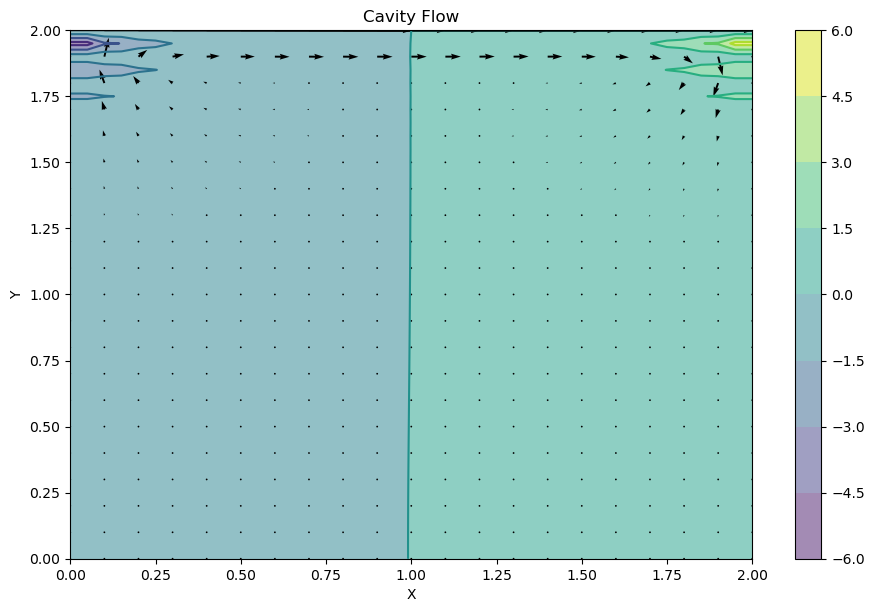

In [12]:
# 41x41 Grid, 100 Timesteps
n = 41
ts = 100
launch_test(n, ts, use_gpu=False, plot_result=True)
launch_test(n, ts, use_gpu=True)

--- Cavity Flow Performance Test ---
Dimension:  256 
Timesteps:  100 
CPU Run
Computation Time (s):  2.857297133654356 
Total Time (s):  2.857924871146679 

--- Cavity Flow Performance Test ---
Dimension:  256 
Timesteps:  100 
GPU Run
Computation Time (s):  1.3204338271170855 
Total Time (s):  1.321460041217506 



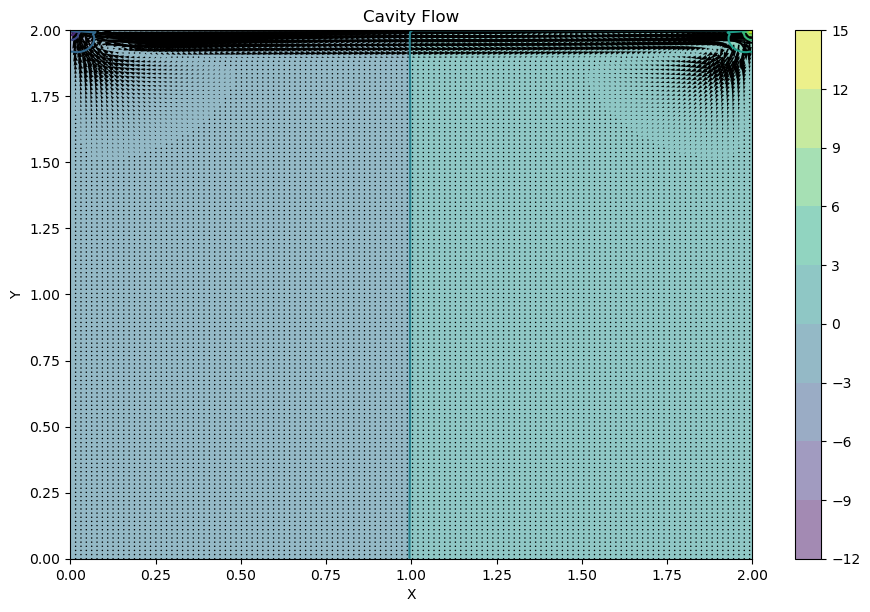

In [13]:
# 256x256 Grid, 100 Timesteps
n = 256
ts = 100
launch_test(n, ts, use_gpu=False, plot_result=True)
launch_test(n, ts, use_gpu=True)

### Plotting Results

Identifying the approximate grid size that it is beneficial to run the code on the GPU:
    
![step11_results](img/step11_results1.png)

Comparing additional grid sizes from 32x32 to 4096x4096, doubling grid size at each point:

![step11_gridsizes](img/perf_logscale.png)

You'll notice the time difference at the 4096x4096 scale where the CPU wall-time executed in 2000 seconds, over 30 minutes, where the GPU wall-time executed in just over 20 seconds.

### Advanced Profiling

CuPy includes Nvidia Tools Extension (NVTX) profiling capabilities that can be imported from the `cupyx.profiler` module.  This allows you to flag and label a function when running the Nsight Systems profiler for your GPU application.

Nsight Systems benchmarking and setting time ranges in the Python code: 

```python
    from cupyx.profiler import time_range, benchmark 

    @time_range()
    def compute(self):
        ...
```

The above code example would flag the `compute` function of our CFD Python program to be profiled.  Any operations will be traced within the generated report.  This can add overhead to your runtime.

To run the Nsys profiler with on your Python GPU application, run the following within your terminal window:
        
```sh
    ### Run
    nsys profile -o step11_profile python step11_cupy_double.py -t cuda,cublas,nvtx -f true
```

The results for a profiled run of 128 gridsize (n) and 500 timesteps (ts) is shown below.  The arguments genereate a profile report called *step11_profile* from the *step11_cupy_double.py* Python file, and will trace Cuda, CuBLAS, and NVTX events when profiling the application.  A detailed overview of the profiler arguments can be found in a previous workshop session.

Nsight Systems generated a report with file extension `.qdrep`.  You can also view this generated report (*step11_profile.qdrep*) in the `code/cfd/cupy` folder if you have previously installed Nsight Systems.  Right click on the file to download it to your local machine.

Nsight Systems GUI viewing the profiled application report:
![nsys_step11.png](img/nsys_step11.png)

If you've used NVTX previously, the NVTX API can be used to annotate sections of your code without CuPy's imported benchmark and timing utilities from the cupyx.profiler.  NVidia provides a tutorial on using NVTX to profile your Python code in more detail:

[Nvidia Tools Extension API for Profiling Python and C code](https://developer.nvidia.com/blog/nvidia-tools-extension-api-nvtx-annotation-tool-for-profiling-code-in-python-and-c-c/)

A previous GPU Workshop session covers Nsight Systems and Compute for profiling:

[NCAR GPU Workshop - Session 10: Hands on Nsight](https://github.com/NCAR/GPU_workshop/tree/workshop/10_HandsOnNsight)

## Additional CuPy Topics

### Custom kernels

Custom kernels in CuPy use C language syntax to write compiled code within Python.  There are code optimization opportunities by writing your own kernels and leveraging concepts of compiled languages and CUDA architecture. Here is a basic example of defining datatypes and calling a custom kernel within Python.

In [14]:
x = cp.arange(6, dtype='f').reshape(2, 3)
y = cp.arange(3, dtype='f')

kernel = cp.ElementwiseKernel(
    'float32 x, float32 y', 'float32 z',
    '''
    if (x - 2 > y) {
      z = x * y;
    } else {
      z = x + y;
    }
    ''', 'my_kernel')

kernel(x, y)

array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]], dtype=float32)

In addition to custom kernels, low-level CUDA features are available:

  - Stream and Event: CUDA stream and per-thread default stream

  - Memory Pool: Customizable memory allocator with a built-in memory pool

  - Host API Binding: Directly call CUDA libraries, such as NCCL, cuDNN, cuTENSOR, and cuSPARSELt APIs from Python

References to get started with custom kernels:

[CuPy User-Defined Kernels](https://docs.cupy.dev/en/stable/user_guide/kernel.html)

[Nvidia Introduction to Cuda Python](https://nvidia.github.io/cuda-python/overview.html)

### Distributed Communication

The cupyx.distributed API can be used to perform communication between different processes in CuPy.  It provides access to the NCCL operations to communication between GPUs using the following arguments and parameters. 


```python
class cupyx.distributed.NCCLBackend(n_devices, rank, host='127.0.0.1', port=13333, use_mpi=False)

"""
Interface that uses NVIDIA’s NCCL to perform communications.

Parameters
    n_devices (int) – Total number of devices that will be used in the distributed execution.

    rank (int) – Unique id of the GPU that the communicator is associated to its value needs to be 0 <= rank < n_devices.

    host (str, optional) – host address for the process rendezvous on initialization. Defaults to “127.0.0.1”.

    port (int, optional) – port used for the process rendezvous on initialization. Defaults to 13333.

    use_mpi (bool, optional) – switch between MPI and use the included TCP server for initialization & synchronization. Defaults to False.
"""
```

In the next session we'll look at using Dask for distributed Multi-GPU programming.

## GeoCAT Example

NCAR's GeoCat team has started exploring the potential of porting computational meteorological code and other scripts to run on GPUs.  GeoCAT is working towards porting the NCAR Command Line scripts to Python and also ways to extend the existing code while porting.

Below is a more formalized version to convert datatypes to run on the GPU using CuPy.  You'll notice the first function checks to see if CuPy can be imported before attempting to use the module for conversion.  This example also shows how you might add Xarray support for your code by converting the Numpy arrays into Xarray compatible datatypes.

```python
def _import_cupy():
    """imports the cupy and checks if not installed."""
    try:
        import cupy as cp
        return cp
    except ImportError as e:
        print(f"Cupy is not installed for GPU computation!")
        pass  # module doesn't exist, deal with it. """
    
def _convert_to_gpu_array(inputs):
    xp = _import_cupy()
    inputs_gpu = []
    in_types = [type(item) for item in inputs]
    if xp.ndarray in in_types:
        #if the inputs are already cupy arrays
        return inputs
    elif np.ndarray in in_types:
        #convert numpy to cupy
        for item in inputs:
            inputs_gpu.append(xp.asarray(item))
    elif xr.DataArray in in_types:
        #convert xarray
        in_types = [type(item.data) for item in inputs]
        if np.ndarray in in_types:
            #xarray with type(item.data) = numpy.ndarray
            for item in inputs:
                inputs_gpu.append(xr.DataArray(xp.asarray(item.data)))
        elif da.Array in in_types:
            #xarray with type(item.data) = dask array
            for item in inputs:
                inputs_gpu.append(xr.DataArray(item.data.map_blocks(
                    xp.asarray)))
        else:
            inputs_gpu = inputs
    elif da.Array in in_types:
        #convert dask array
        for item in inputs:
            inputs_gpu.append(item.map_blocks(xp.asarray))
    else:
        return inputs
    return inputs_gpu
```
*Source: NCAR SIParCS 2022 Haniye Kashgarani (Implementation of GeoCAT on GPUs)*

This code is in the process of being pushed to production with the goal of integration directly into the main branch using the device agnostic approach shown earlier in the notebook.  GeoCAT is Open Development and you can contribute via their GitHub page.  Instructions for contributing are included on their website and via the link below.

[GeoCat Homepage](https://geocat.ucar.edu/)

[Contribute to GeoCat](https://geocat.ucar.edu/pages/contributing.html)

----

# Legate

Legate is another option for drop-in replacement for accelerated Python GPU code.  Numpy and Pandas are supported for drop-in replacement via Legate.cuNumerics and Legate.Pandas, respectively. 

Legate's approach to Python GPU acceleration:

  1) The programming model must be identical to programming a single sequential CPU on their laptop or desktop. All concerns relating to parallelism, data distribution, and synchronization must be implicit. 
  2) Software must be compositional and not just interoperable (i.e. functionally correct). Libraries developed in the Legate ecosystem must be able to exchange partitioned and distributed data without requiring "shuffles" or unnecessary blocking synchronization.
 
These two core concepts of Legate reduce the effort of the developer and shifts the memory management responsibilities onto the backend of the Legate Core API.

## Setup

Legate uses a driver script to launch your Python GPU programs.  The legate driver script is in the bin directory of the Legate installation directory. Note that the default python interpreter (python) will not work with programs that use Legate libraries, you need to use this custom driver script.

For example, to run your script in the default configuration (4 CPUs cores and 4 GB of memory) run:

``` Python
installdir/bin/legate my_python_program.py [other args]
```

Documentation on downloading and installing Legate can be found here:

https://github.com/nv-legate/legate.core

## CuNumerics

### Numpy Drop-in Replacement

After installing the Legate Core library, the next step is to install a Legate application library such as cuNumeric. The installation process for a Legate application library will require you to provide a pointer to the location of your Legate Core library installation as this will be used to configure the installation of the Legate application library. After you finish installing any Legate application libraries, you can then simply replace their import statements with the equivalent ones from any Legate application libraries you have installed. For example, you can change this:

```python
import numpy as np
```

to this:

```python
import cunumeric as np
```



## Legate.Pandas

### Pandas Drop-in Replacement

Legate Pandas is a distributed and accelerated drop-in replacement of Pandas. Legate Pandas enables high-performance, scalable execution of dataframe programs on multi-GPU systems by combining the Legion runtime with GPU accelerated dataframe kernels in cuDF. Legate Pandas targets dataframe programs with data processing requirements that cannot be fulfilled by a single GPU.  Legate.Pandas provides an alternative to a CuDF+Dask implementation.

The process to use Legate.Pandas is the same as CuNumerics, using a simple drop-in:

```python
import pandas as pd
```

with this:

```python
import legate.pandas as pd
```

## Legate Resources

[Legate Main Resource](https://github.com/nv-legate/)

[Legate CuNumeric](https://github.com/nv-legate/cunumeric)

[Legate Pandas](https://github.com/nv-legate/legate.pandas)

[NVidia Scaling the PyData Ecosystem with Legate](https://www.nvidia.com/en-us/on-demand/session/gtcfall21-a31168/)

# Resources

[CuPy Website and Documentation](https://docs.cupy.dev/en/stable/index.html)

[12 Steps to CFD GitHub](https://github.com/barbagroup/CFDPython)

[12 Steps to CFD Main page](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/)

[GRACE Data NCAR](https://climatedataguide.ucar.edu/climate-data/grace-gravity-recovery-and-climate-experiment-surface-mass-total-water-storage-and)

[GRACE Data CU](http://geoid.colorado.edu/grace/index.html)

[Python Intrepreter and How Python Works](https://towardsdatascience.com/how-does-python-work-6f21fd197888)